# Session 5 - Bloc Transformer & Mini-GPT (Partie 1)

**Module** : Réseaux de Neurones Approfondissement  
**Durée** : 2h  
**Objectif** : Assembler un bloc Transformer complet et commencer à générer des noms de Pokémon

---

## Objectifs pédagogiques

À la fin de cette session, vous serez capable de :
1. Assembler un **bloc Transformer** complet (MHA + FFN + résiduel)
2. Comprendre l'architecture d'un **décodeur** (GPT)
3. Créer un **tokenizer character-level**
4. Entraîner un **Mini-GPT** pour générer des noms de Pokémon

---

## Rappel : Où en sommes-nous ?

Sessions précédentes :
- ✅ `scaled_dot_product_attention()` 
- ✅ `MultiHeadAttention` (avec split/concat heads)
- ✅ `FeedForward` Network
- ✅ LayerNorm + Résiduel
- ✅ Masque causal (GPT vs BERT)

Aujourd'hui, on **assemble tout** et on passe à la **génération** !

## 0. Installation et imports

In [1]:
!pip install torch matplotlib numpy datasets -q


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)

# Device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU disponible: {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
    print("CPU uniquement")

print(f"PyTorch version: {torch.__version__}")

CPU uniquement
PyTorch version: 2.10.0


---

## 1. Rappel : Nos briques de base

Chargeons les composants des sessions précédentes.

In [3]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """Scaled Dot-Product Attention."""
    d_k = K.shape[-1]
    scores = Q @ K.transpose(-2, -1) / math.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask, float('-inf'))
    
    attention_weights = F.softmax(scores, dim=-1)
    output = attention_weights @ V
    return output, attention_weights


class MultiHeadAttention(nn.Module):
    """Multi-Head Attention."""
    
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.d_k = embed_dim // num_heads
        
        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)
    
    def split_heads(self, x):
        batch_size, seq_len, _ = x.shape
        x = x.view(batch_size, seq_len, self.num_heads, self.d_k)
        return x.transpose(1, 2)
    
    def concat_heads(self, x):
        batch_size, _, seq_len, _ = x.shape
        x = x.transpose(1, 2).contiguous()
        return x.view(batch_size, seq_len, self.embed_dim)
    
    def forward(self, x, mask=None):
        Q = self.split_heads(self.W_q(x))
        K = self.split_heads(self.W_k(x))
        V = self.split_heads(self.W_v(x))
        
        attn_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
        concat_output = self.concat_heads(attn_output)
        output = self.W_o(concat_output)
        
        return output, attn_weights


class FeedForward(nn.Module):
    """Feed-Forward Network."""
    
    def __init__(self, embed_dim, ff_dim=None, dropout=0.1):
        super().__init__()
        if ff_dim is None:
            ff_dim = 4 * embed_dim
        
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x


print("✅ Composants chargés")

✅ Composants chargés


---

## 2. Exercice 1 : Assembler le bloc Transformer

Un bloc Transformer combine :
1. **Multi-Head Attention** + résiduel + LayerNorm
2. **Feed-Forward** + résiduel + LayerNorm

### Architecture (Pre-LN)

```
Input
  │
  ├───────────────────┐
  ↓                   │
LayerNorm             │
  ↓                   │
Multi-Head Attention  │
  ↓                   │
Dropout               │
  ↓                   │
  + ←─────────────────┘ (résiduel)
  │
  ├───────────────────┐
  ↓                   │
LayerNorm             │
  ↓                   │
Feed-Forward          │
  ↓                   │
Dropout               │
  ↓                   │
  + ←─────────────────┘ (résiduel)
  ↓
Output
```

In [4]:
class TransformerBlock(nn.Module):
    """
    Un bloc Transformer complet (Pre-LN).

    Architecture : LayerNorm AVANT attention/FFN (plus stable à l'entraînement),
    avec connexions résiduelles et dropout.
    """

    def __init__(self, embed_dim, num_heads, ff_dim=None, dropout=0.1):
        super().__init__()

        if ff_dim is None:
            ff_dim = 4 * embed_dim

        # Sous-couches
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.feed_forward = FeedForward(embed_dim, ff_dim, dropout)

        # Normalisations (Pre-LN)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Dropouts
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # ----- 1) Self-Attention + Résiduel (Pre-LN) -----
        residual = x
        x = self.norm1(x)
        x, _ = self.attention(x, mask=mask)   # (B, T, D)
        x = self.dropout1(x)
        x = x + residual

        # ----- 2) Feed-Forward + Résiduel (Pre-LN) -----
        residual = x
        x = self.norm2(x)
        x = self.feed_forward(x)              # (B, T, D)
        x = self.dropout2(x)
        x = x + residual

        return x


In [5]:
# Test
block = TransformerBlock(embed_dim=64, num_heads=4, dropout=0.1)

x = torch.randn(2, 10, 64)  # batch=2, seq=10, embed=64
out = block(x)

print(f"Input shape:  {x.shape}")    # (2, 10, 64)
print(f"Output shape: {out.shape}")  # Attendu: (2, 10, 64)

if out is not None and out.shape == (2, 10, 64):
    print("\n✅ Correct !")
else:
    print("\n❌ Vérifiez votre implémentation")

# Paramètres
n_params = sum(p.numel() for p in block.parameters())
print(f"\nParamètres du bloc: {n_params:,}")

Input shape:  torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])

✅ Correct !

Paramètres du bloc: 49,984


---

## 3. Vous savez construire un Transformer !

### Récapitulatif

```
┌─────────────────────────────────────────────────────────────┐
│                      TRANSFORMER                            │
├─────────────────────────────────────────────────────────────┤
│  Tokens → Embedding → Positional Encoding                   │
│                          ↓                                  │
│  ┌─────────────────────────────────────────┐                │
│  │         TransformerBlock × N            │                │
│  │  ┌─────────────────────────────────┐    │                │
│  │  │  LayerNorm → MHA → Dropout → +  │    │                │
│  │  │  LayerNorm → FFN → Dropout → +  │    │                │
│  │  └─────────────────────────────────┘    │                │
│  └─────────────────────────────────────────┘                │
│                          ↓                                  │
│                    LayerNorm final                          │
│                          ↓                                  │
│                   Couche de sortie                          │
└─────────────────────────────────────────────────────────────┘
```

**Maintenant, utilisons-le pour générer du texte !**

---

# PARTIE 2 : Mini-GPT - Générer des noms de Pokémon

## 4. Introduction au projet

### Objectif

Créer un **Mini-GPT** qui génère des **noms de Pokémon** inventés !

```
Input:  "Pika"    →  Output: "Pikarion"
Input:  "Dra"     →  Output: "Dracofeu"
Input:  "Flam"    →  Output: "Flamirex"
```

### Pourquoi character-level ?

- **Simple** : Vocabulaire de ~50 caractères (vs 50k tokens pour GPT-2)
- **Rapide** : Entraînement en quelques minutes
- **Pédagogique** : On voit clairement la génération caractère par caractère
- **Fun** : Les noms inventés sont souvent amusants !

### Dataset

**1211 noms de Pokémon** en français (Pikachu, Dracaufeu, Mewtwo...)

Chargement du dataset des noms de Pokémon...

✅ 1211 noms chargés

Exemples :
  - Abo
  - Abra
  - Absol
  - Aflamanoir
  - Airmure
  - Akwakwak
  - Alakazam
  - Aligatueur
  - Altaria
  - Ama-Ama
  ...
Longueur des noms :
  Min: 3 caractères
  Max: 30 caractères
  Moyenne: 9.3 caractères
  Médiane: 9.0 caractères
  Q1: 7.0 | Q3: 10.0


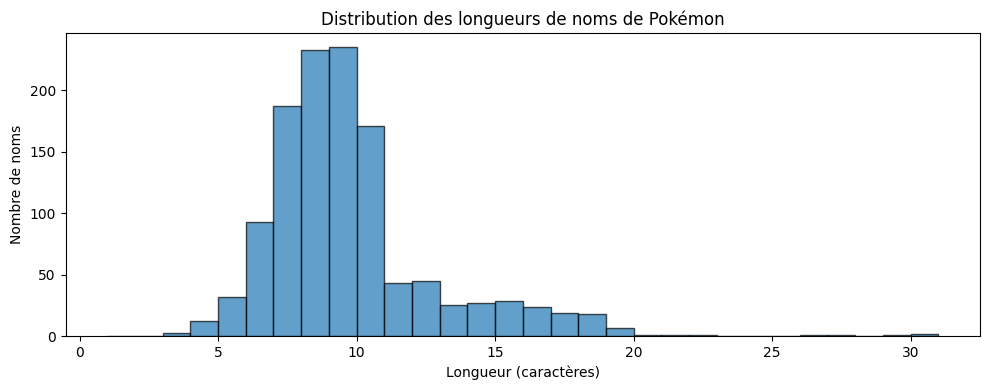

In [23]:
# Exercice : Statistiques de longueur des noms
# Objectif : calculer et visualiser la distribution des longueurs

# Charger le dataset
from datasets import load_dataset

print("Chargement du dataset des noms de Pokémon...")
dataset = load_dataset("chris-lmd/pokemon-names-fr")

# Extraire les noms
pokemon_names = [item["name"] for item in dataset["train"]]

print(f"\n✅ {len(pokemon_names)} noms chargés")
print(f"\nExemples :")
for name in pokemon_names[:10]:
    print(f"  - {name}")
print(f"  ...")

import numpy as np
import matplotlib.pyplot as plt

# 1) TODO : Construire la liste des longueurs (en caractères)
lengths = [len(name) for name in pokemon_names]

# 2) TODO : Calculer et afficher des statistiques
# - min, max, moyenne, médiane
# - quartiles (Q1, Q3)
# Exemple (à adapter) :
min_len = min(lengths)
max_len = max(lengths)
mean_len = sum(lengths) / len(lengths)
med_len = np.median(lengths)
q1, q3 = np.percentile(lengths, [25, 75])
print("Longueur des noms :")
print(f"  Min: {min_len} caractères")
print(f"  Max: {max_len} caractères")
print(f"  Moyenne: {mean_len:.1f} caractères")
print(f"  Médiane: {med_len:.1f} caractères")
print(f"  Q1: {q1:.1f} | Q3: {q3:.1f}")

# 3) TODO : Tracer l'histogramme des longueurs
# Choisir des `bins`, un style, et ajouter des titres/axes
plt.figure(figsize=(10, 4))
bins = range(1, max_len + 2)
plt.hist(lengths, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel("Longueur (caractères)")
plt.ylabel("Nombre de noms")
plt.title("Distribution des longueurs de noms de Pokémon")
plt.tight_layout()
plt.show()

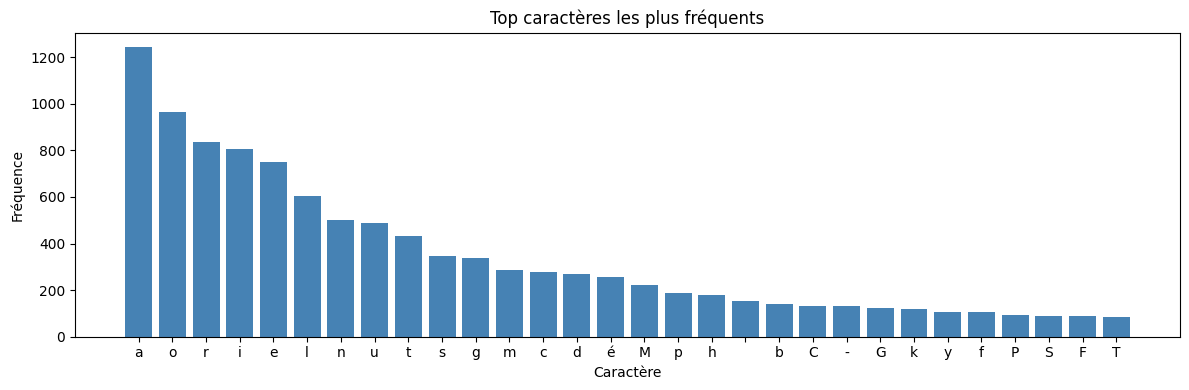

In [24]:
# Exercice : Fréquence des caractères (top K)
# Objectif : compter les caractères et visualiser leur fréquence

from collections import Counter
import matplotlib.pyplot as plt

# TODO : Construire la liste de tous les caractères
all_chars = []
for name in pokemon_names:
    all_chars.extend(list(name))

# TODO : Compter et choisir K
char_counts = Counter(all_chars)
top_k = 30  # à ajuster

# TODO : Préparer les données pour la visualisation
items = char_counts.most_common(top_k)
labels = [c for c, n in items]
values = [n for c, n in items]

# TODO : Tracer le bar chart
plt.figure(figsize=(12, 4))
plt.bar(labels, values, color="steelblue")
plt.title("Top caractères les plus fréquents")
plt.xlabel("Caractère")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

Longueur des noms :
  Min: 3 caractères
  Max: 30 caractères
  Moyenne: 9.3 caractères
  Médiane: 9.0 caractères
  Q1: 7.0 | Q3: 10.0


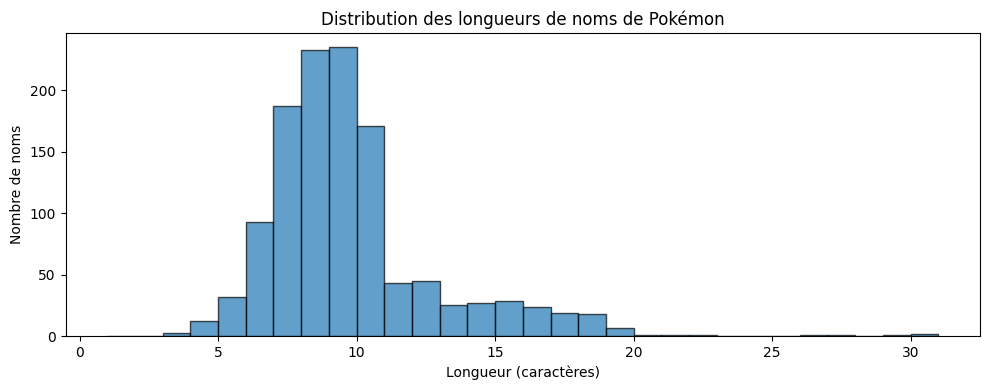

In [25]:
# Exercice : Statistiques de longueur des noms
# Objectif : calculer et visualiser la distribution des longueurs

import numpy as np
import matplotlib.pyplot as plt

# 1) TODO : Construire la liste des longueurs (en caractères)
lengths = [len(name) for name in pokemon_names]

# 2) TODO : Calculer et afficher des statistiques
# - min, max, moyenne, médiane
min_len = min(lengths)
max_len = max(lengths)
mean_len = sum(lengths) / len(lengths)
med_len = np.median(lengths)
q1, q3 = np.percentile(lengths, [25, 75])
print("Longueur des noms :")
print(f"  Min: {min_len} caractères")
print(f"  Max: {max_len} caractères")
print(f"  Moyenne: {mean_len:.1f} caractères")
print(f"  Médiane: {med_len:.1f} caractères")
print(f"  Q1: {q1:.1f} | Q3: {q3:.1f}")

# 3) TODO : Tracer l'histogramme des longueurs
plt.figure(figsize=(10, 4))
bins = range(1, max_len + 2)
plt.hist(lengths, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel("Longueur (caractères)")
plt.ylabel("Nombre de noms")
plt.title("Distribution des longueurs de noms de Pokémon")
plt.tight_layout()
plt.show()

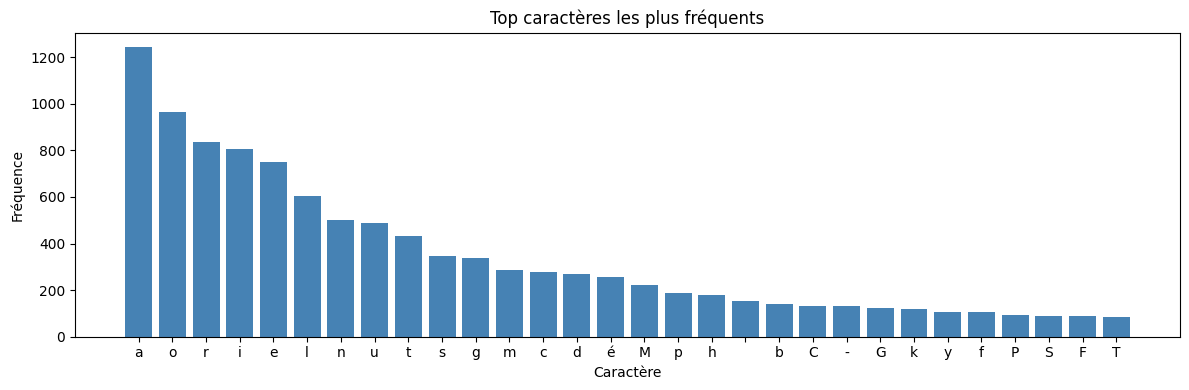

In [26]:
# Exercice : Fréquence des caractères (top K)
# Objectif : compter les caractères et visualiser leur fréquence

from collections import Counter
import matplotlib.pyplot as plt

# TODO : Construire la liste de tous les caractères
all_chars = []
for name in pokemon_names:
    all_chars.extend(list(name))

# TODO : Compter et choisir K
char_counts = Counter(all_chars)
top_k = 30  # à ajuster

# TODO : Préparer les données pour la visualisation
items = char_counts.most_common(top_k)
labels = [c for c, n in items]
values = [n for c, n in items]

# TODO : Tracer le bar chart
plt.figure(figsize=(12, 4))
plt.bar(labels, values, color="steelblue")
plt.title("Top caractères les plus fréquents")
plt.xlabel("Caractère")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

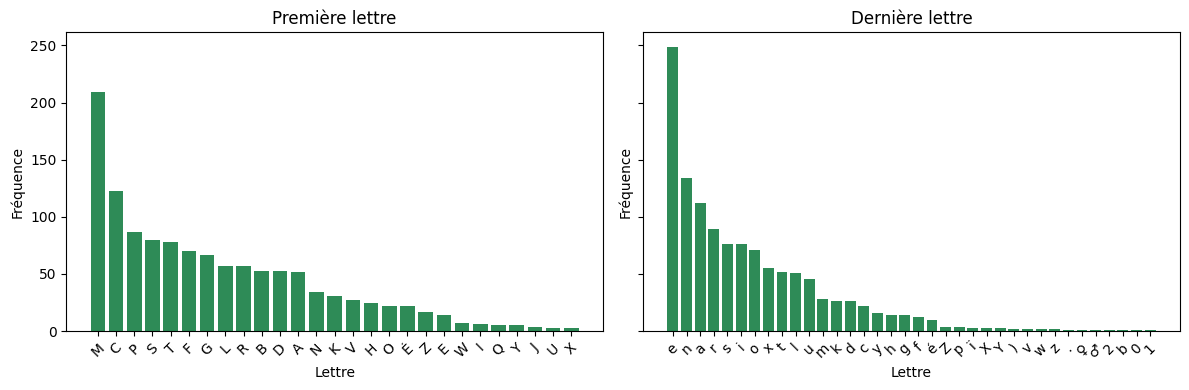

In [27]:
# Exercice : Distribution des premières et dernières lettres
# Objectif : compter et visualiser la fréquence des premières/dernières lettres

from collections import Counter
import matplotlib.pyplot as plt

# TODO : Extraire les premières et dernières lettres (ignorer les chaînes vides)
first_letters = [name[0] for name in pokemon_names if name]
last_letters  = [name[-1] for name in pokemon_names if name]

# TODO : Compter les fréquences
first_counts = Counter(first_letters)
last_counts  = Counter(last_letters)

# TODO : Visualiser (bar charts côte à côte)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, title, counts in zip(axes, ["Première lettre", "Dernière lettre"], [first_counts, last_counts]):
    items = sorted(counts.items(), key=lambda x: -x[1])
    labels = [c for c, n in items]
    values = [n for c, n in items]
    ax.bar(labels, values, color="seagreen")
    ax.set_title(title)
    ax.set_xlabel("Lettre")
    ax.set_ylabel("Fréquence")
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

---

## 5. Tokenizer character-level

### Principe

Chaque **caractère** = un token

```
"Pikachu" → ['P', 'i', 'k', 'a', 'c', 'h', 'u'] → [23, 12, 14, 4, 6, 11, 24]
```

### Vocabulaire

On ajoute des tokens spéciaux :
- `<PAD>` : Padding (remplissage)
- `<BOS>` : Begin Of Sequence (début)
- `<EOS>` : End Of Sequence (fin)

In [8]:
class CharTokenizer:
    """
    Tokenizer character-level simple.
    """
    
    def __init__(self, texts):
        """
        Construit le vocabulaire à partir d'une liste de textes.
        """
        # Tokens spéciaux
        self.pad_token = "<PAD>"
        self.bos_token = "<BOS>"
        self.eos_token = "<EOS>"
        
        # Collecter tous les caractères uniques
        all_chars = set()
        for text in texts:
            all_chars.update(text)
        
        # Créer le vocabulaire
        special_tokens = [self.pad_token, self.bos_token, self.eos_token]
        chars = sorted(list(all_chars))
        
        self.vocab = special_tokens + chars
        self.vocab_size = len(self.vocab)
        
        # Mappings
        self.char_to_idx = {c: i for i, c in enumerate(self.vocab)}
        self.idx_to_char = {i: c for i, c in enumerate(self.vocab)}
        
        # IDs des tokens spéciaux
        self.pad_id = self.char_to_idx[self.pad_token]
        self.bos_id = self.char_to_idx[self.bos_token]
        self.eos_id = self.char_to_idx[self.eos_token]
    
    def encode(self, text, add_special_tokens=True):
        """
        Convertit un texte en liste d'indices.
        """
        ids = [self.char_to_idx.get(c, self.pad_id) for c in text]
        
        if add_special_tokens:
            ids = [self.bos_id] + ids + [self.eos_id]
        
        return ids
    
    def decode(self, ids, skip_special_tokens=True):
        """
        Convertit une liste d'indices en texte.
        """
        chars = []
        for idx in ids:
            token = self.idx_to_char.get(idx, "")
            
            if skip_special_tokens and token in [self.pad_token, self.bos_token, self.eos_token]:
                continue
            
            chars.append(token)
        
        return "".join(chars)
    
    def __len__(self):
        return self.vocab_size

In [9]:
# Créer le tokenizer
tokenizer = CharTokenizer(pokemon_names)

print(f"Taille du vocabulaire: {tokenizer.vocab_size}")
print(f"\nVocabulaire: {tokenizer.vocab}")

# Test
test_name = "Pikachu"
encoded = tokenizer.encode(test_name)
decoded = tokenizer.decode(encoded)

print(f"\nTest :")
print(f"  Original: {test_name}")
print(f"  Encodé:   {encoded}")
print(f"  Décodé:   {decoded}")

Taille du vocabulaire: 76

Vocabulaire: ['<PAD>', '<BOS>', '<EOS>', ' ', "'", '(', ')', ',', '-', '.', '0', '1', '2', ':', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'É', 'â', 'ç', 'è', 'é', 'ê', 'ï', 'ô', '♀', '♂']

Test :
  Original: Pikachu
  Encodé:   [1, 29, 48, 50, 40, 42, 47, 60, 2]
  Décodé:   Pikachu


---

## 6. Exercice 2 : Dataset PyTorch

Pour entraîner le modèle, on crée des paires **(input, target)**.

### Principe : prédire le caractère suivant

Le modèle GPT apprend à prédire le **prochain caractère** à chaque position.
Grâce au **masque causal**, à chaque position il ne voit que ce qui précède :

| Position | Le modèle voit | Doit prédire |
|----------|----------------|--------------|
| 0 | `[BOS]` | `P` |
| 1 | `[BOS] P` | `i` |
| 2 | `[BOS] P i` | `k` |
| 3 | `[BOS] P i k` | `a` |
| ... | ... | ... |
| 7 | `[BOS] P i k a c h u` | `[EOS]` |

### Construction des paires Input/Target

Pour la séquence `[BOS] P i k a c h u [EOS]` :
- **Input** : `[BOS] P i k a c h u` (tout sauf le dernier)
- **Target** : `P i k a c h u [EOS]` (tout sauf le premier)

À chaque position `i`, le modèle prédit `target[i]` en ne voyant que `input[0:i+1]`.

In [10]:
class PokemonNameDataset(Dataset):
    """
    Dataset pour l'entraînement du générateur de noms.

    Objectif : prédire le prochain token (next-token prediction).
    Pour une séquence ids = [BOS, ..., EOS, PAD, PAD, ...]
    on renvoie :
      x = ids[:-1]
      y = ids[1:]
    """

    def __init__(self, names, tokenizer, max_len=32):
        self.tokenizer = tokenizer
        self.max_len = max_len

        self.data = []
        for name in names:
            ids = tokenizer.encode(name)
            if len(ids) <= max_len:
                self.data.append(ids)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ids = self.data[idx]

        # Padding jusqu'à max_len
        pad_len = self.max_len - len(ids)
        ids_padded = ids + [self.tokenizer.pad_id] * pad_len

        # Décalage d'un token : entrée vs cible
        x = torch.tensor(ids_padded[:-1], dtype=torch.long)
        y = torch.tensor(ids_padded[1:], dtype=torch.long)

        return x, y


In [11]:
# Créer le dataset
dataset_pokemon = PokemonNameDataset(pokemon_names, tokenizer, max_len=32)

print(f"Nombre d'exemples: {len(dataset_pokemon)}")

# Voir un exemple
x, y = dataset_pokemon[0]
print(f"\nExemple :")
print(f"  Input (x):  {x[:10].tolist()}...")
print(f"  Target (y): {y[:10].tolist()}...")
print(f"\n  Décodé x: '{tokenizer.decode(x.tolist())}'")
print(f"  Décodé y: '{tokenizer.decode(y.tolist())}'")

if x is not None and y is not None and x.shape == y.shape:
    print("\n✅ Correct !")
else:
    print("\n❌ Vérifiez votre implémentation")

Nombre d'exemples: 1211

Exemple :
  Input (x):  [1, 14, 41, 54, 2, 0, 0, 0, 0, 0]...
  Target (y): [14, 41, 54, 2, 0, 0, 0, 0, 0, 0]...

  Décodé x: 'Abo'
  Décodé y: 'Abo'

✅ Correct !


---

## 7. Architecture Mini-GPT

Notre Mini-GPT est un **décodeur** (comme GPT) avec :
- Token embeddings
- Position embeddings (apprenables)
- N blocs Transformer avec **masque causal**
- Tête de sortie (prédiction du prochain caractère)

In [12]:
class MiniGPT(nn.Module):
    """
    Mini-GPT pour la génération de texte character-level.
    """
    
    def __init__(self, vocab_size, embed_dim=64, num_heads=4, num_layers=4, 
                 ff_dim=256, max_seq_len=32, dropout=0.1):
        super().__init__()
        
        self.max_seq_len = max_seq_len
        
        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Blocs Transformer
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        
        # Sortie
        self.ln_final = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)
        
        # Masque causal pré-calculé : chaque position ne voit que les précédentes
        # C'est ce qui distingue GPT (décodeur) de BERT (encodeur bidirectionnel)
        # Cf. Session 4 pour l'explication détaillée du masque causal
        self.register_buffer(
            "causal_mask",
            torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()
        )
        
        # Compter les paramètres
        n_params = sum(p.numel() for p in self.parameters())
        print(f"Mini-GPT: {n_params:,} paramètres ({n_params/1e3:.1f}K)")
    
    def forward(self, x):
        """
        Args:
            x: Token indices, shape (batch, seq_len)
        Returns:
            logits: shape (batch, seq_len, vocab_size)
        """
        batch_size, seq_len = x.shape
        
        # Embeddings
        positions = torch.arange(seq_len, device=x.device)
        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(positions)
        x = self.dropout(tok_emb + pos_emb)
        
        # Masque causal (tronqué à la longueur actuelle)
        mask = self.causal_mask[:seq_len, :seq_len]
        
        # Blocs Transformer
        for block in self.blocks:
            x = block(x, mask)
        
        # Sortie
        x = self.ln_final(x)
        logits = self.head(x)
        
        return logits
    
    @torch.no_grad()
    def generate(self, prompt_ids, max_new_tokens=20, temperature=1.0):
        """
        Génère du texte à partir d'un prompt.
        
        Args:
            prompt_ids: Liste d'indices du prompt
            max_new_tokens: Nombre max de tokens à générer
            temperature: Contrôle la "créativité" (1.0 = normal, <1 = conservateur, >1 = créatif)
        """
        self.eval()
        
        # Convertir en tensor
        x = torch.tensor([prompt_ids], dtype=torch.long, device=next(self.parameters()).device)
        
        for _ in range(max_new_tokens):
            # Tronquer si nécessaire
            x_cond = x if x.size(1) <= self.max_seq_len else x[:, -self.max_seq_len:]
            
            # Forward
            logits = self(x_cond)
            logits = logits[:, -1, :] / temperature  # Dernier token
            
            # Sampling
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            # Ajouter le nouveau token
            x = torch.cat([x, next_token], dim=1)
            
            # Stop si EOS
            if next_token.item() == tokenizer.eos_id:
                break
        
        return x[0].tolist()

In [13]:
# Créer le modèle
model = MiniGPT(
    vocab_size=tokenizer.vocab_size,
    embed_dim=64,
    num_heads=4,
    num_layers=4,
    ff_dim=256,
    max_seq_len=32,
    dropout=0.1
).to(device)

# Test forward
x_test = torch.randint(0, tokenizer.vocab_size, (2, 10)).to(device)
logits = model(x_test)
print(f"\nTest forward:")
print(f"  Input:  {x_test.shape}")
print(f"  Output: {logits.shape}")

Mini-GPT: 211,916 paramètres (211.9K)

Test forward:
  Input:  torch.Size([2, 10])
  Output: torch.Size([2, 10, 76])


---

## 8. Entraînement

On entraîne le modèle à prédire le **caractère suivant** (cross-entropy loss).

In [14]:
# Configuration
BATCH_SIZE = 64
LEARNING_RATE = 3e-4
NUM_EPOCHS = 50

# DataLoader
dataloader = DataLoader(dataset_pokemon, batch_size=BATCH_SIZE, shuffle=True)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Loss (ignore le padding)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)

print(f"Batch size: {BATCH_SIZE}")
print(f"Batches par epoch: {len(dataloader)}")
print(f"Epochs: {NUM_EPOCHS}")

Batch size: 64
Batches par epoch: 19
Epochs: 50


In [15]:
# Fonction d'entraînement
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        
        # Forward
        logits = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def generate_sample(model, tokenizer, prompt="", temperature=0.8):
    """Génère un nom à partir d'un prompt."""
    if prompt:
        prompt_ids = [tokenizer.bos_id] + [tokenizer.char_to_idx.get(c, tokenizer.pad_id) for c in prompt]
    else:
        prompt_ids = [tokenizer.bos_id]
    
    output_ids = model.generate(prompt_ids, max_new_tokens=20, temperature=temperature)
    return tokenizer.decode(output_ids)

In [16]:
# Entraînement
print("Début de l'entraînement...\n")

losses = []
for epoch in range(NUM_EPOCHS):
    loss = train_epoch(model, dataloader, optimizer, criterion, device)
    losses.append(loss)
    
    # Afficher la progression
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | Loss: {loss:.4f}")
        
        # Générer un exemple
        sample = generate_sample(model, tokenizer, prompt="")
        print(f"  Exemple: {sample}")

print("\n✅ Entraînement terminé !")

Début de l'entraînement...

Epoch   1/50 | Loss: 4.1467
  Exemple: 
Epoch  10/50 | Loss: 2.6861
  Exemple: Faliuntiu
Epoch  20/50 | Loss: 2.4351
  Exemple: Pinica
Epoch  30/50 | Loss: 2.2956
  Exemple: Tonbopauch
Epoch  40/50 | Loss: 2.1917
  Exemple: Nimostore
Epoch  50/50 | Loss: 2.0941
  Exemple: Mimigol

✅ Entraînement terminé !


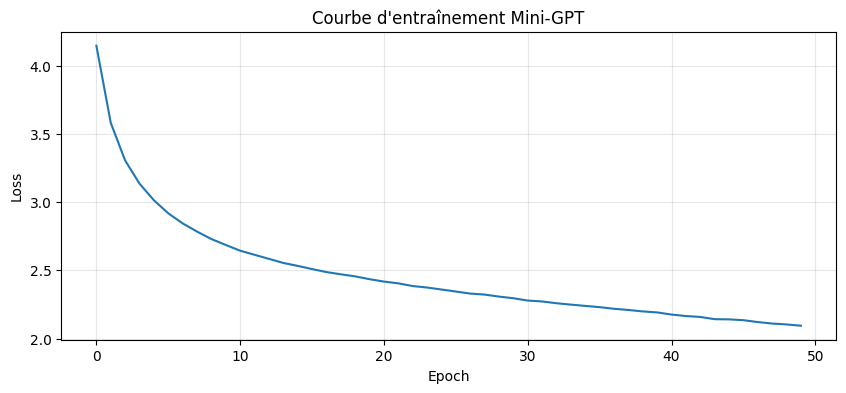

In [17]:
# Courbe de loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe d'entraînement Mini-GPT")
plt.grid(True, alpha=0.3)
plt.show()

---

## 9. Génération de noms !

Testons notre modèle avec différents prompts.

In [18]:
# Générer des noms avec différents prompts
prompts = ["Pika", "Dra", "Flam", "Aqua", "Méga", ""]

print("Noms de Pokémon générés :\n")
print("-" * 40)

for prompt in prompts:
    names = [generate_sample(model, tokenizer, prompt, temperature=0.8) for _ in range(3)]
    
    if prompt:
        print(f"Prompt '{prompt}' :")
    else:
        print(f"Sans prompt :")
    
    for name in names:
        print(f"  → {name}")
    print()

Noms de Pokémon générés :

----------------------------------------
Prompt 'Pika' :
  → Pikarang
  → Pikakido
  → Pikaltet

Prompt 'Dra' :
  → Dratron
  → Drangon
  → Drangol

Prompt 'Flam' :
  → Flamira
  → Flamimou Gigamamax
  → Flamito

Prompt 'Aqua' :
  → Aqualouss
  → Aquarde de Blalala
  → Aquangn

Prompt 'Méga' :
  → Méga-Shintiga
  → Méga-Flamich
  → Méga-Alokeroce

Sans prompt :
  → Grabime
  → Cadene
  → Lésgraco



In [19]:
# Effet de la température (leur poser la question ce qu'est la température)
print("Effet de la température :\n")

for temp in [0.5, 0.8, 1.0, 1.5]:
    print(f"Temperature = {temp} :")
    names = [generate_sample(model, tokenizer, "Pika", temperature=temp) for _ in range(5)]
    print(f"  {', '.join(names)}")
    print()

Effet de la température :

Temperature = 0.5 :
  Pikalin, Pikaro, Pikapa, Pikamin, Pikanin

Temperature = 0.8 :
  Pikapon, Pikanta, Pikalin, Pikaman, Pikamin

Temperature = 1.0 :
  Pikavon, Pikachyz, Pikazi, Pikapy, Pikampik

Temperature = 1.5 :
  Pikarfe, Pikamélo, Pikapun wCPy YyARr, Pikaxjos, Pikagax



---

## 10. Récapitulatif

### Ce que nous avons fait

1. ✅ Assemblé un **bloc Transformer** complet
2. ✅ Créé un **tokenizer character-level**
3. ✅ Implémenté **Mini-GPT** (décodeur avec masque causal)
4. ✅ Entraîné sur **1211 noms de Pokémon**
5. ✅ Généré des **noms inventés** !

### Prochaine session

On va :
1. **Fine-tuner GPT-2** français sur le corpus Pokémon complet
2. Générer des **descriptions** de Pokémon
3. Créer un **pipeline complet** : nom + description = nouveau Pokémon !

In [20]:
# Sauvegarder le modèle (optionnel)
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': tokenizer.vocab,
}, 'minigpt_pokemon_names.pt')

print("✅ Modèle sauvegardé: minigpt_pokemon_names.pt")

✅ Modèle sauvegardé: minigpt_pokemon_names.pt
